# California

## Contents
- [Imports](#Data-Dictionary)
- [Regression Modeling](#Regression-Modeling)  
- [Classification Modeling](#Classification-Modeling)  

# Imports

In [1]:
# Import the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, confusion_matrix, plot_confusion_matrix, plot_roc_curve, f1_score, accuracy_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm  import SVR, SVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer, QuantileTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier 
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier

In [2]:
# Import the Texas data and sae to a dataframe.
df = pd.read_csv('../data/cleaned_engineered_ca.csv')

In [3]:
# Display the first few rows of the dataframe.
df.head(2)

,county_state,total_cases,total_fatalities,death_rate,total_tests,race_pop,race_pop_hispanic_or_latino_of_any_race,race_pop_white_alone,race_pop_black_or_african_american_alone,race_pop_american_indian_and_alaska_native_alone,...,percent_race_pop_other,percent_race_pop_minority,percent_sex_age_pop_0_to_44,percent_sex_age_pop_45_to_74,percent_sex_age_pop_75_and_over,percent_sex_age_pop_0_to_64,percent_sex_age_pop_65_and_over,percent_sex_age_pop_0_to_35,percent_sex_age_pop_35_to_59,percent_sex_age_pop_60_to_84
0,"Santa Clara County, California",23978.0,388.0,0.016181,839764,1922200,495455,615912,45379,3003,...,0.041717,0.679580,0.616108,0.327238,0.056655,0.871549,0.128451,0.469933,0.348772,0.163722
1,"San Mateo County, California",10942.0,159.0,0.014531,285657,765935,189002,303047,16838,1151,...,0.058196,0.604344,0.574618,0.357939,0.067443,0.846114,0.153886,0.430888,0.353295,0.192727


# Regression Modeling

## Explainable Model: GridSearchCV with Quantile, SelectKBest, Ridge: 68%

In [4]:
# Assign our features to X.
X = df[[
    'percent_race_pop_hispanic_or_latino_of_any_race',
    'percent_sex_age_pop_under_5',
    'percent_sex_age_pop_5_to_9',
    'percent_sex_age_pop_10_to_14',
    'percent_sex_age_pop_15_to_19',
    'obes_percent',
    'percent_sex_age_pop_25_to_34',
    'percent_inc_hhlds_35_000_to_49_999',
    'sex_age_pop_20_to_24',
    'percent_sex_age_pop_male',
    'percent_health_ins_noninst_pop_cov_no',
    'tests_per_100_people',
    'percent_sex_age_pop_35_to_44',
    'percent_race_pop_white_alone',    
    'percent_sex_age_pop_45_to_74',
    'percent_sex_age_pop_75_and_over',
    'percent_race_pop_two_or_more_races',
    'inc_per_capita_inc_dol',
    'pop_density'
]]

y = df['cases_per_100_people']

# Split X and y into train/test groups.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
# Display the shape of the training data.
X_train.shape

(43, 19)

In [6]:
X_test.shape

(15, 19)

In [7]:
# Create a main pipeline that will contain the dtype pipelines and the estimator.
pipe = make_pipeline(QuantileTransformer(), SelectKBest(f_regression), Ridge(max_iter=20_000))

# Set parameters for GridSearchCV.
params = {
    'selectkbest__k': range(1,20),
    'ridge__alpha': [.1, 1, 10, 20]
}

# Set up GridSearchCV with the pipe and R2 as the scoring method.
gs = GridSearchCV(pipe, param_grid=params, scoring='r2', cv=10, n_jobs=-1)

In [8]:
# Call fit on the GridSearchCV object and pass the training  data.
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('quantiletransformer',
                                        QuantileTransformer()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7f3c78d6fd40>)),
                                       ('ridge', Ridge(max_iter=20000))]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [0.1, 1, 10, 20],
                         'selectkbest__k': range(1, 20)},
             scoring='r2')

In [9]:
# Display the best parameters.
gs.best_params_

{'ridge__alpha': 1, 'selectkbest__k': 15}

In [10]:
# Display the score for the test set.
gs.score(X_test, y_test)

0.6803632096961685

In [11]:
# Display the score for the train set.
gs.score(X_train, y_train)

0.7806475654936332

In [12]:
# Calculate the RMSE for the model.
y_preds = gs.predict(X_test)
print('RMSE of Model:', mean_squared_error(y_test, y_preds, squared=False))

RMSE of Model: 0.7361979535491971


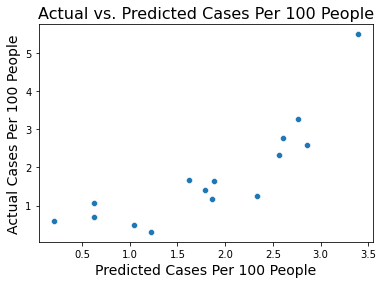

In [13]:
# Plot the predicted sale price versus the actual 'cases_per_100_people'
plt.figure(figsize=(6,4))
sns.scatterplot(y_preds, y_test)
plt.title('Actual vs. Predicted Cases Per 100 People', fontsize=16)
plt.xlabel('Predicted Cases Per 100 People', fontsize=14)
plt.ylabel('Actual Cases Per 100 People', fontsize=14);

In [14]:
# Extract a boolean matrix of features selectkbest used in the best model.
features = gs.best_estimator_.named_steps['selectkbest'].get_support()
features

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
       False])

In [15]:
features = X_train.columns[features==True]

In [16]:
features

Index(['percent_race_pop_hispanic_or_latino_of_any_race',
       'percent_sex_age_pop_under_5', 'percent_sex_age_pop_5_to_9',
       'percent_sex_age_pop_10_to_14', 'percent_sex_age_pop_15_to_19',
       'obes_percent', 'percent_sex_age_pop_25_to_34', 'sex_age_pop_20_to_24',
       'tests_per_100_people', 'percent_sex_age_pop_35_to_44',
       'percent_race_pop_white_alone', 'percent_sex_age_pop_45_to_74',
       'percent_sex_age_pop_75_and_over', 'percent_race_pop_two_or_more_races',
       'inc_per_capita_inc_dol'],
      dtype='object')

In [17]:
# Extract the coefficients for the features used in the best model.
coefs = gs.best_estimator_.named_steps['ridge'].coef_

In [18]:
coefs.shape

(15,)

In [19]:
coefs

array([ 0.50169769,  0.31870195,  0.31296203,  0.45933941, -0.1805425 ,
       -0.11199446,  0.12448592,  0.39614919,  0.85401913, -0.38059114,
       -0.61358013, -0.68024461,  0.02999153, -0.88918687, -0.47513588])

In [20]:
coef_df = pd.DataFrame(list(zip(features, coefs)), columns=['Feature', 'cases_per_100_people'])
coef_df = coef_df.set_index('Feature')
coef_df = coef_df.sort_values(by='cases_per_100_people', ascending=False)

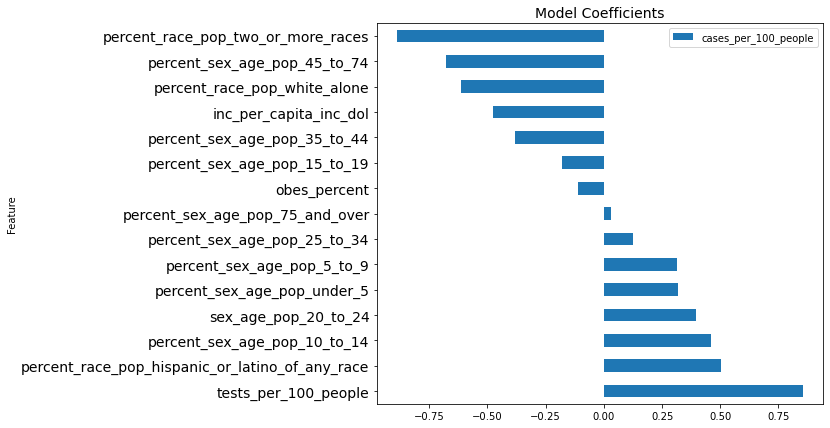

In [21]:
# Plot the datatframe of the top 10 word and their coefficients.
coef_df.plot(kind = 'barh', figsize=(8,7))
plt.title('Model Coefficients', fontsize=14)
plt.yticks(fontsize=14);

## Blackbox Model: Quantile, Polynomial, Gridsearch, Ridge: 72%

In [22]:
# Assign our features to X.
X = df[[
    'obes_percent',
    'pop_density',
    'sex_age_median_age_in_years',
    'inc_med_hhld_inc_dol',
    'inc_mean_hhld_inc_dol',
    'inc_per_capita_inc_dol',
    'inc_med_earn_male_full_yr_workers_dol',
    'inc_med_earn_female_full_yr_workers_dol',
    'percent_race_pop_hispanic_or_latino_of_any_race',
    'percent_race_pop_white_alone',
    'percent_race_pop_black_or_african_american_alone',
    'percent_race_pop_american_indian_and_alaska_native_alone',
    'percent_race_pop_asian_alone',
    'percent_race_pop_native_hawaiian_and_other_pacific_islander_alone',
    'percent_race_pop_some_other_race_alone',
    'percent_race_pop_two_or_more_races',
    'percent_sex_age_pop_male',
    'percent_sex_age_pop_female',
    'percent_sex_age_pop_under_5',
    'percent_sex_age_pop_5_to_9',
    'percent_sex_age_pop_10_to_14',
    'percent_sex_age_pop_15_to_19',
    'percent_sex_age_pop_20_to_24',
    'percent_sex_age_pop_25_to_34',
    'percent_sex_age_pop_35_to_44',
    'percent_sex_age_pop_45_to_54',
    'percent_sex_age_pop_55_to_59',
    'percent_sex_age_pop_60_to_64',
    'percent_sex_age_pop_65_to_74',
    'percent_sex_age_pop_75_to_84',
    'percent_sex_age_pop_85_and_over',
    'percent_health_ins_noninst_pop_cov_yes',
    'percent_health_ins_noninst_pop_cov_no',
    'percent_inc_hhlds_less_than_10_000',
    'percent_inc_hhlds_10_000_to_14_999',
    'percent_inc_hhlds_15_000_to_24_999',
    'percent_inc_hhlds_25_000_to_34_999',
    'percent_inc_hhlds_35_000_to_49_999',
    'percent_inc_hhlds_50_000_to_74_999',
    'percent_inc_hhlds_75_000_to_99_999',
    'percent_inc_hhlds_100_000_to_149_999',
    'percent_inc_hhlds_150_000_to_199_999',
    'percent_inc_hhlds_200_000_or_more',
]]

y = df['cases_per_100_people']

# Split X and y into train/test groups.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [23]:
# Display the shape of the training data.
X_train.shape

(43, 43)

In [24]:
# Create a main pipeline that will contain the dtype pipelines and the estimator.
pipe = make_pipeline(QuantileTransformer(), PolynomialFeatures(), SelectKBest(f_regression), Ridge(max_iter=20_000))

# Set parameters for GridSearchCV.
params = {
    'selectkbest__k': range(1,300),
    'ridge__alpha': [.1, 1, 10, 20]
}

# Set up GridSearchCV with the pipe and R2 as the scoring method.
gs = GridSearchCV(pipe, param_grid=params, scoring='r2', cv=10, n_jobs=-1)

In [25]:
# Call fit on the GridSearchCV object and pass the training  data.
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('quantiletransformer',
                                        QuantileTransformer()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7f3c78d6fd40>)),
                                       ('ridge', Ridge(max_iter=20000))]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [0.1, 1, 10, 20],
                         'selectkbest__k': range(1, 300)},
             scoring='r2')

In [26]:
# Display the best parameters.
gs.best_params_

{'ridge__alpha': 0.1, 'selectkbest__k': 1}

In [27]:
# Display the score for the test set.
gs.score(X_test, y_test)

0.7210852471826901

In [28]:
# Display the score for the train set.
gs.score(X_train, y_train)

0.7038999692544085

In [29]:
# Calculate the RMSE for the model.
y_preds = gs.predict(X_test)
print('RMSE of Model:', mean_squared_error(y_test, y_preds, squared=False))

RMSE of Model: 0.6877046621233236


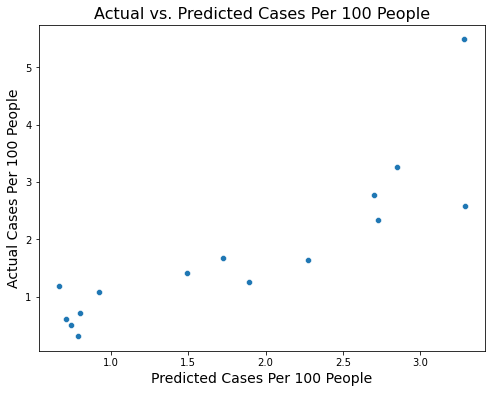

In [30]:
# Plot the predicted sale price versus the actual sale price
plt.figure(figsize=(8,6))
sns.scatterplot(y_preds, y_test)
plt.title('Actual vs. Predicted Cases Per 100 People', fontsize=16)
plt.xlabel('Predicted Cases Per 100 People', fontsize=14)
plt.ylabel('Actual Cases Per 100 People', fontsize=14);

# Classification Modeling

## Simple(r) Model: GridSearchCV with Classifier: 93% (baseline 66)

In [31]:
# Assign our features to X.
X = df[[
    'percent_race_pop_hispanic_or_latino_of_any_race',
    'percent_sex_age_pop_under_5',
    'percent_sex_age_pop_5_to_9',
    'percent_sex_age_pop_10_to_14',
    'percent_sex_age_pop_15_to_19',
    'obes_percent',
    'percent_race_pop_white_alone',
    'percent_sex_age_pop_45_to_74',
    'percent_sex_age_pop_75_and_over',
    'inc_per_capita_inc_dol'
]]

y = df['covid_severity']

# Split X and y into train/test groups.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [32]:
# Display the shape of the training data.
X_train.shape

(43, 10)

In [33]:
# Create a main pipeline that will contain the dtype pipelines and the estimator.
pipe = make_pipeline(StandardScaler(), SelectKBest(), LogisticRegression())

# Set parameters for GridSearchCV.
params = {
    'selectkbest__k': range(1,300),
    'logisticregression__C': [.1, .5, 1, 10]
}

# Set up GridSearchCV with the pipe and R2 as the scoring method.
gs = GridSearchCV(pipe, param_grid=params, cv=10, n_jobs=-1)

In [34]:
# Call fit on the GridSearchCV object and pass the training  data.
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.1, 0.5, 1, 10],
                         'selectkbest__k': range(1, 300)})

In [35]:
# Display the best parameters.
gs.best_params_

{'logisticregression__C': 0.5, 'selectkbest__k': 4}

In [36]:
# Display the score for the test set.
gs.score(X_test, y_test)

0.9333333333333333

In [37]:
# Display the score for the train set.
gs.score(X_train, y_train)

0.9302325581395349

In [38]:
y_preds = gs.predict(X_test)

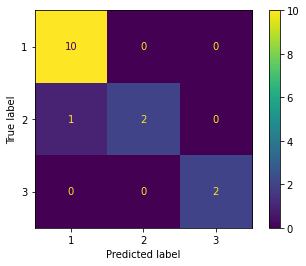

In [39]:
# Plot the predicted sale price versus the actual sale price
plot_confusion_matrix(gs, X_test, y_test);

In [40]:
# Extract a boolean matrix of features selectkbest used in the best model.
features = gs.best_estimator_.named_steps['selectkbest'].get_support()
features

array([ True,  True, False,  True, False, False, False,  True, False,
       False])

In [41]:
features = X_train.columns[features==True]

In [42]:
features

Index(['percent_race_pop_hispanic_or_latino_of_any_race',
       'percent_sex_age_pop_under_5', 'percent_sex_age_pop_10_to_14',
       'percent_sex_age_pop_45_to_74'],
      dtype='object')

In [43]:
# Extract the coefficients for the features used in the best model.
coefs = gs.best_estimator_.named_steps['logisticregression'].coef_

In [44]:
coefs.shape

(3, 4)

In [45]:
coefs

array([[-0.96219975, -0.28153929, -0.39437644,  0.77245983],
       [ 0.38982899, -0.43497166,  0.00870767, -0.2629217 ],
       [ 0.57237076,  0.71651095,  0.38566877, -0.50953813]])

In [46]:
coef1 = coefs[0]
coef2 = coefs[1]
coef3 = coefs[2]

In [47]:
pd.DataFrame(list(zip(features, coef1)), columns=['Feature', 'covid_severity_1'])

,Feature,covid_severity_1
0,percent_race_pop_hispanic_or_latino_of_any_race,-0.962200
1,percent_sex_age_pop_under_5,-0.281539
2,percent_sex_age_pop_10_to_14,-0.394376
3,percent_sex_age_pop_45_to_74,0.772460


In [48]:
pd.DataFrame(list(zip(features, coef2)), columns=['Feature', 'covid_severity_2'])

,Feature,covid_severity_2
0,percent_race_pop_hispanic_or_latino_of_any_race,0.389829
1,percent_sex_age_pop_under_5,-0.434972
2,percent_sex_age_pop_10_to_14,0.008708
3,percent_sex_age_pop_45_to_74,-0.262922


In [49]:
pd.DataFrame(list(zip(features, coef3)), columns=['Feature', 'covid_severity_3'])

,Feature,covid_severity_3
0,percent_race_pop_hispanic_or_latino_of_any_race,0.572371
1,percent_sex_age_pop_under_5,0.716511
2,percent_sex_age_pop_10_to_14,0.385669
3,percent_sex_age_pop_45_to_74,-0.509538
